## Imports

In [354]:
import pandas as pd
import glob
import datasets
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [280]:
wiki_data = pd.read_csv("../../data/wikidata/wikidata-property-list.csv")
wiki_data = wiki_data[["Title", "ID", "Datatype", "Description"]]

In [4]:
code_to_lang_dict = {
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hr": "Croatian",
    "hu": "Hungarian",
    "it": "Italian",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sl": "Slovenian",
    "sr": "Serbian",
    "sv": "Swedish",
    "uk": "Ukrainian",
}

In [5]:
lang_to_code_dict = {v: k for k, v in code_to_lang_dict.items()}

In [6]:
results_dict = {}
results_dict["language"] = []
results_dict["relation"] = []
results_dict["percentage change"] = []
results_dict["new ratio of rows"] = []
results_dict["old ratio of rows"] = []

hf_df = datasets.load_dataset("CalibraGPT/Fact-Completion")
file_names = glob.glob("../../data/result_logs/llama-30b/error-analysis/*.csv")

# confirm grabbing data correctly against LLaMa figure
# uncomment print statement at end of for loop to see
results_dfs = []
count = 0
for file in file_names:
    language = file.split(".csv")[0].split("-")[-1].capitalize()
    error_df = pd.read_csv(file)
    full_hf_df = hf_df[file.split(".csv")[0].split("-")[-1].capitalize()]
    full_hf_df = full_hf_df.to_pandas()
    
    # stem is in both
    # dataset id is in both
    # to see if the model got something wrong, see if the dataset id in the full df is in the error
    error_ids = list(error_df["dataset_id"])
    correct = []
    counts = []
    relation_names = []
    for row in full_hf_df.iterrows():
        # track counts
        count += 1
        counts.append(count)
        # track errors
        correct.append(False) if row[1]["dataset_id"] in error_ids else correct.append(
            True
        )
        # track relation titles
        relation_id = int(row[1].relation[1:])
        relation_title = list(wiki_data[wiki_data["ID"] == relation_id]["Title"])[0]
        relation_names.append(relation_title)

    # append result to full df
    full_hf_df["correct"] = correct
    # append language to full df
    full_hf_df["language"] = [language] * full_hf_df.shape[0]
    # append language code to full df
    lang_code = lang_to_code_dict[language]
    full_hf_df["lang_code"] = [lang_code] * full_hf_df.shape[0]
    # append relation title to full df
    full_hf_df["relation_title"] = relation_names
    # also append an arbitrary id to have unique val for each row
    full_hf_df["analysis_id"] = counts

    results_dfs.append(full_hf_df)

results_df = pd.concat(results_dfs)
assert results_df.shape[0] == count

Found cached dataset parquet (/Users/tim/.cache/huggingface/datasets/CalibraGPT___parquet/CalibraGPT--Fact-Completion-24a24a1e4bf6e4a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/20 [00:00<?, ?it/s]

for Serbian we got 2170 wrong out of 5426
for Ukrainian we got 2138 wrong out of 7918
for Dutch we got 3309 wrong out of 22590
for Swedish we got 3440 wrong out of 21576
for Hungarian we got 1128 wrong out of 4650
for Catalan we got 3021 wrong out of 18898
for Polish we got 2137 wrong out of 9484
for Russian we got 996 wrong out of 3289
for Bulgarian we got 5658 wrong out of 20577
for Slovenian we got 1890 wrong out of 7873
for English we got 2782 wrong out of 26254
for German we got 2323 wrong out of 16287
for Portuguese we got 3719 wrong out of 22974
for Czech we got 2080 wrong out of 9427
for Spanish we got 3430 wrong out of 18786
for Croatian we got 1715 wrong out of 7358
for Danish we got 4255 wrong out of 23365
for French we got 2910 wrong out of 18395
for Italian we got 3192 wrong out of 20448
for Romanian we got 3035 wrong out of 17568


## Explore Data

In [7]:
results_df.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5


In [286]:
# average number of times a dataset_id gets shared across langs?
# 11.5
np.mean(results_df["dataset_id"].value_counts())

11.546545288337015

<Axes: title={'center': 'Average Dataset ID usage'}, ylabel='Frequency'>

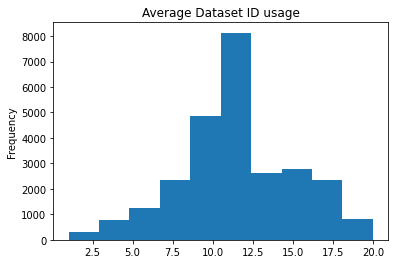

In [290]:
# hist of our usage
results_df["dataset_id"].value_counts().plot(kind='hist', title='Average Dataset ID usage')

how many dataset_id's get used across all 20 langs?

In [10]:
np.count_nonzero(results_df["dataset_id"].value_counts().values == 20)

214

how many dataset_id's get used across only 1 lang?

In [11]:
np.count_nonzero(results_df["dataset_id"].value_counts().values == 1)

77

our prius fact appears in 15 cuts -- *if* you don't take into account translations

In [83]:
results_df[results_df["subject"] == "Prius"].shape[0]

15

look at all the versions of our prius fact, which appears in *16* cuts, when you take into account that its translated in serbian differently than the romanized form.

In [84]:
results_df[results_df["dataset_id"] == "calinet_8922"].shape[0]

16

## More Cleanup to Ensure that we have access to Subjects across langs

In [74]:
# mapping between dataset id and the english form of a subject
dataset_id_to_eng_subject = {}
for row in results_df.iterrows():
    if row[1].language == 'English':
        if row[1].dataset_id not in dataset_id_to_eng_subject:
            dataset_id_to_eng_subject[row[1].dataset_id] = row[1].subject

In [73]:
# put in an id and get the english subject back
dataset_id_to_eng_subject['rome_21844']

'Megan Rapinoe'

In [111]:
entities = {}
for row in results_df.iterrows():
    # gather helpful row level data
    # the subject
    subject = row[1].subject
    # whether the model got it right
    val = row[1].correct
    # the dataset id
    dataset_id = row[1].dataset_id
    # the english version of the subject
    english_subject = dataset_id_to_eng_subject[dataset_id]

    # commit it to our tracking dict
    if english_subject not in entities:
        entities[english_subject] = {"correct": 0, "incorrect": 0, "langs": {}, "alternate_forms": {}, "dataset_ids": set()}
    
    # counter of correct/incorrect for that subject
    if val:
        entities[english_subject]["correct"] += 1
    else:
        entities[english_subject]["incorrect"] += 1
     
    # track language
    lang = row[1].lang_code
    
    if lang not in entities[english_subject]["langs"]:
        entities[english_subject]["langs"][lang] = 1

    else:
        entities[english_subject]["langs"][lang] += 1
    
    # track any alternate forms
    entities[english_subject]["alternate_forms"][lang] = subject
    
    entities[english_subject]["dataset_ids"].add(dataset_id)

In [117]:
entity_names = []
correct = []
incorrect = []
total = []
pct = []
langs = []
num_langs = []
alternate_forms = []
dataset_ids = []
for k, v in entities.items():
    entity_names.append(k)
    # track # of times entity is used in a correct statement, incorrect, and pct accuracy
    correct.append(v["correct"])
    incorrect.append(v["incorrect"])
    total.append(int(v["correct"]) + int(v["incorrect"]))
    pct.append(int(v["correct"]) / (int(v["correct"]) + int(v["incorrect"])))
    # track # of languages the entity is used in
    langs.append(v["langs"])
    num_langs.append(len(v["langs"]))
    alternate_forms.append(v["alternate_forms"])
    # track dataset ids its used in
    dataset_ids.append(list(v["dataset_ids"]))
    # sanity check
    assert((int(v["correct"]) + int(v["incorrect"]) == sum(v["langs"].values())))

In [298]:
# the average entity appears in ~12 langs
# (remember that this will max out at 20.)
np.mean(num_langs)

11.867738745323988

In [119]:
entity_analysis_df = pd.DataFrame(
    {
        "entity": entity_names,
        "num_correct": correct,
        "num_incorrect": incorrect,
        "total_usages": total,
        "percent_accuracy": pct,
        "languages": langs,
        "num_languages": num_langs,
        "alternate_forms": alternate_forms,
        "dataset_ids": dataset_ids
    }
)

In [268]:
entity_analysis_df.head(2)

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Prius,16,0,16,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",16,"{'sr': 'Приус', 'uk': 'Prius', 'nl': 'Prius', ...",[calinet_8922]
1,Sundar Pichai,18,1,19,0.947368,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Сундар Пицхаи', 'uk': 'Сундар Пічаї', ...",[rome_5025]


## Most Correct and Incorrect by Raw Count

### Most Correct

top 10 most correct (by raw count)

In [282]:
entity_analysis_df.sort_values(by="num_incorrect", ascending=False)[:10]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
344,They,174,315,489,0.355828,"{'sr': 18, 'uk': 22, 'nl': 27, 'sv': 31, 'hu':...",20,"{'sr': 'Они', 'uk': 'Вони', 'nl': 'They', 'sv'...","[calinet_12932, calinet_12566, calinet_2272, c..."
1072,European Union,74,68,142,0.521127,"{'sr': 7, 'uk': 3, 'nl': 10, 'sv': 7, 'hu': 5,...",20,"{'sr': 'Европска унија', 'uk': 'Європейський С...","[rome_10474, rome_6214, rome_15290, rome_21264..."
1454,Tree Hill,6,42,48,0.125000,"{'sr': 2, 'uk': 3, 'nl': 1, 'sv': 3, 'ca': 3, ...",19,"{'sr': 'Трее Хилл', 'uk': 'Tree Hill', 'nl': '...","[calinet_4819, calinet_4962, calinet_4804]"
3509,Doctor Who,50,41,91,0.549451,"{'sr': 1, 'uk': 2, 'nl': 6, 'sv': 5, 'hu': 2, ...",20,"{'sr': 'Лекар који', 'uk': 'Лікар, який', 'nl'...","[calinet_7590, calinet_8076, calinet_4572, rom..."
4960,Cam-Pact,4,33,37,0.108108,"{'sr': 1, 'uk': 2, 'nl': 2, 'sv': 2, 'hu': 2, ...",20,"{'sr': 'Цам-Пацт', 'uk': 'Cam-Pact', 'nl': 'Ca...","[rome_14029, calinet_12903]"
684,VAX,4,32,36,0.111111,"{'sr': 2, 'uk': 2, 'nl': 2, 'sv': 2, 'ca': 2, ...",19,"{'sr': 'ВАКС', 'uk': 'VAX', 'nl': 'VAX', 'sv':...","[calinet_8905, calinet_8606]"
2389,ice cream cone,50,32,82,0.609756,"{'sr': 3, 'uk': 3, 'nl': 6, 'sv': 6, 'hu': 3, ...",19,"{'sr': 'корнет за сладолед', 'uk': 'ріжок моро...","[rome_18400, rome_12775, rome_16755, rome_872,..."
1252,China,101,32,133,0.759398,"{'sr': 2, 'uk': 2, 'nl': 10, 'sv': 11, 'hu': 2...",20,"{'sr': 'Кина', 'uk': 'Китай', 'nl': 'China', '...","[calinet_2641, calinet_2782, calinet_459, cali..."
5570,Sushi Pack,1,31,32,0.031250,"{'uk': 2, 'nl': 2, 'sv': 2, 'ca': 2, 'pl': 2, ...",17,"{'uk': 'Sushi Pack', 'nl': 'Sushi Pack', 'sv':...","[rome_8450, calinet_4657]"
1378,Life Unexpected,3,30,33,0.090909,"{'sr': 2, 'uk': 1, 'nl': 2, 'sv': 2, 'ca': 2, ...",19,"{'sr': 'Лифе Унекпецтед', 'uk': 'Life Unexpect...","[calinet_4836, calinet_4598]"


### Most Incorrect

top 10 most incorrect (by raw count)

In [284]:
entity_analysis_df.sort_values(by="num_correct", ascending=False)[:10]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
344,They,174,315,489,0.355828,"{'sr': 18, 'uk': 22, 'nl': 27, 'sv': 31, 'hu':...",20,"{'sr': 'Они', 'uk': 'Вони', 'nl': 'They', 'sv'...","[calinet_12932, calinet_12566, calinet_2272, c..."
1162,Russia,157,24,181,0.867403,"{'sr': 4, 'uk': 3, 'nl': 13, 'sv': 11, 'hu': 4...",20,"{'sr': 'Русија', 'uk': 'Росія', 'nl': 'Rusland...","[calinet_3479, calinet_2526, calinet_2584, cal..."
2825,South Africa,116,2,118,0.983051,"{'sr': 2, 'uk': 2, 'nl': 11, 'sv': 8, 'hu': 2,...",20,"{'sr': 'Јужна Африка', 'uk': 'Південна Африка'...","[rome_10612, calinet_3031, calinet_66, calinet..."
4364,Germany,113,19,132,0.856061,"{'sr': 1, 'uk': 2, 'nl': 12, 'sv': 10, 'hu': 2...",20,"{'sr': 'Немачка', 'uk': 'Німеччина', 'nl': 'Du...","[calinet_2502, calinet_478, calinet_364, calin..."
2494,Hungary,103,13,116,0.887931,"{'sr': 1, 'nl': 12, 'sv': 8, 'hu': 1, 'ca': 7,...",18,"{'sr': 'Мађарска', 'nl': 'Hongarije', 'sv': 'U...","[calinet_142, rome_17071, calinet_2879, caline..."
1140,India,102,8,110,0.927273,"{'sr': 2, 'uk': 4, 'nl': 9, 'sv': 5, 'hu': 3, ...",20,"{'sr': 'Индија', 'uk': 'Індія', 'nl': 'India',...","[calinet_2501, calinet_60, calinet_2634, calin..."
1252,China,101,32,133,0.759398,"{'sr': 2, 'uk': 2, 'nl': 10, 'sv': 11, 'hu': 2...",20,"{'sr': 'Кина', 'uk': 'Китай', 'nl': 'China', '...","[calinet_2641, calinet_2782, calinet_459, cali..."
845,France,98,3,101,0.970297,"{'sr': 2, 'uk': 2, 'nl': 8, 'sv': 8, 'hu': 2, ...",20,"{'sr': 'Француска', 'uk': 'Франція', 'nl': 'Fr...","[rome_17806, calinet_2519, calinet_257, caline..."
5,Iran,98,6,104,0.942308,"{'sr': 3, 'uk': 2, 'nl': 8, 'sv': 8, 'hu': 3, ...",20,"{'sr': 'Иран', 'uk': 'Іран', 'nl': 'Iran', 'sv...","[calinet_3044, calinet_482, calinet_231, calin..."
1203,Belgium,97,4,101,0.960396,"{'sr': 3, 'uk': 2, 'nl': 9, 'sv': 7, 'hu': 2, ...",20,"{'sr': 'Белгија', 'uk': 'Бельгія', 'nl': 'Belg...","[rome_18642, calinet_3034, rome_19222, rome_11..."


<Axes: title={'center': 'Average Accuracy per Entity'}, ylabel='Frequency'>

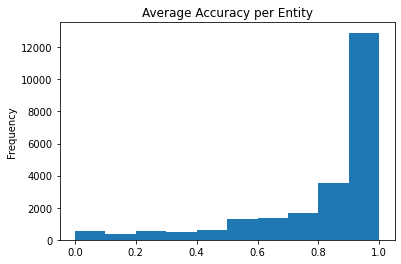

In [267]:
entity_analysis_df["percent_accuracy"].plot(kind='hist', title='Average Accuracy per Entity')

## Most Correct and Incorrect by Percent (at least 10 usages)

there are 6496 entities that were used more than 10 times and always correct!

In [103]:

len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]
)

6496

and they comprise 88k of our corrects.

In [269]:
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]["total_usages"]
)

88138

there were just 238 entities that were consistently bad

In [270]:
len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]
)

238

and they comprise just 3405 of our incorrect

In [271]:
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]["total_usages"]
)

3405

subset of some of the 238 entities bad entities

In [275]:
entity_analysis_df[
    (entity_analysis_df["total_usages"] >= 10)
    & (entity_analysis_df["percent_accuracy"] == 0.0)
][-5:][['entity', 'num_languages']]

,entity,num_languages
20504,James Royce Shannon,11
20519,Thomas Browne,12
20865,Geraldine McNulty,10
20886,Aunty Disco Project,11
21426,Kazimierz Nycz,10


## Most Correct and Incorrect by Percent (no usage minimum)

how many entities do we always get right?

In [301]:
len(entity_analysis_df[entity_analysis_df["percent_accuracy"] == 1.0])

8902

In [304]:
entity_analysis_df[entity_analysis_df["percent_accuracy"] == 1.0].head()

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Prius,16,0,16,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",16,"{'sr': 'Приус', 'uk': 'Prius', 'nl': 'Prius', ...",[calinet_8922]
2,People's Republic of China,17,0,17,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",17,"{'sr': 'Народна Република Кина', 'uk': 'Народн...",[rome_21333]
8,Fortran,18,0,18,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'Фортран', 'uk': 'Fortran', 'nl': 'Fort...",[rome_18369]
10,MacBook Pro,18,0,18,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'МацБоок Про', 'uk': 'MacBook Pro', 'nl...",[rome_17929]
27,Peter O'Sullevan,19,0,19,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Петер О'Суллеван', 'uk': 'Пітер О'Салл...",[rome_2619]


how many entities do we always get wrong?

In [303]:
len(entity_analysis_df[entity_analysis_df["percent_accuracy"] == 0.0])

322

In [306]:
entity_analysis_df[entity_analysis_df["percent_accuracy"] == 0.0].head()

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
49,Visible World,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Видљиви свет', 'uk': 'Видимий світ', '...",[calinet_12615]
79,John McEntee,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Јохн МцЕнтее', 'uk': 'John McEntee', '...",[calinet_12605]
185,Alphonse,0,8,8,0.0,"{'sr': 1, 'ca': 1, 'en': 1, 'de': 1, 'pt': 1, ...",8,"{'sr': 'Алпхонсе', 'ca': 'Alphonse', 'en': 'Al...",[calinet_1789]
212,Tom Leopold,0,15,15,0.0,"{'sr': 1, 'nl': 1, 'sv': 1, 'ca': 1, 'pl': 1, ...",15,"{'sr': 'Том Леополд', 'nl': 'Tom Leopold', 'sv...",[rome_19964]
221,Barry Pilton,0,15,15,0.0,"{'sr': 1, 'nl': 1, 'sv': 1, 'ca': 1, 'pl': 1, ...",15,"{'sr': 'Барри Пилтон', 'nl': 'Barry Pilton', '...",[calinet_5398]


## Analyzing a Single Entity

In [276]:
def get_lang_usage_report_for_entity(entity_val):
    usage_dict = entity_analysis_df[entity_analysis_df['entity'] == entity_val]['languages'].values[0]
        
    usage_dict = {code_to_lang_dict[k]: {'correct': 0, 'incorrect': 0} for k, v in usage_dict.items()}
    # ok, how many of those usages are correct vs not?
    dataset_ids = list(entity_analysis_df[entity_analysis_df['entity'] == entity_val]['dataset_ids'])[0]
    
    for dataset_id in dataset_ids:
        subset = results_df[results_df['dataset_id'] == dataset_id]
        for row in subset.iterrows():
            lang_used = row[1].language
            correct = row[1].correct
            
            if correct:
                usage_dict[lang_used]['correct'] += 1
            else:
                usage_dict[lang_used]['incorrect'] += 1
                                
    return usage_dict

In [327]:
def get_percent_correct_from_usage_report(usage_report):
    correct = 0
    incorrect = 0
    for l in usage_report.keys():
        correct += usage_report[l]['correct']
        incorrect += usage_report[l]['incorrect']
    return np.round(correct / (correct + incorrect) * 100, 2)

In [328]:
kerala_usage = get_lang_usage_report_for_entity('Kerala')
kerala_usage

{'Serbian': {'correct': 1, 'incorrect': 0},
 'Ukrainian': {'correct': 3, 'incorrect': 0},
 'Dutch': {'correct': 5, 'incorrect': 1},
 'Swedish': {'correct': 4, 'incorrect': 0},
 'Catalan': {'correct': 5, 'incorrect': 1},
 'Polish': {'correct': 3, 'incorrect': 0},
 'Bulgarian': {'correct': 5, 'incorrect': 0},
 'Slovenian': {'correct': 2, 'incorrect': 0},
 'English': {'correct': 6, 'incorrect': 0},
 'German': {'correct': 6, 'incorrect': 0},
 'Portuguese': {'correct': 6, 'incorrect': 0},
 'Czech': {'correct': 3, 'incorrect': 0},
 'Spanish': {'correct': 3, 'incorrect': 1},
 'Croatian': {'correct': 1, 'incorrect': 0},
 'Danish': {'correct': 6, 'incorrect': 0},
 'French': {'correct': 5, 'incorrect': 0},
 'Italian': {'correct': 5, 'incorrect': 0},
 'Romanian': {'correct': 5, 'incorrect': 0}}

In [329]:
get_percent_correct_from_usage_report(kerala_usage)

96.1

In [330]:
def get_rows_by_entity(entity_val, outcome = False):
    ids = list(entity_analysis_df[entity_analysis_df['entity'] == entity_val]['dataset_ids'])[0]
    return results_df[(results_df['dataset_id'].isin(ids)) & (results_df['correct'] == outcome)]

In [331]:
get_rows_by_entity('Kerala')

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
11211,rome_16815,In Kerala verstaan ​​ze <br> In Kerala begrijp...,Engels,Fins,P37,Kerala,Engels,False,Dutch,nl,official language,24556
9395,rome_16815,"A Kerala, entenen <br> A Kerala, entenen el",Anglès,finès,P37,Kerala,Anglès,False,Catalan,ca,official language,71556
9320,rome_16815,En Kerala entienden,Inglés,finlandés,P37,Kerala,Inglés,False,Spanish,es,official language,206544


## How Many Entities Are 

- Always Correct
- Sometimes Correct
- Never Correct

In [348]:
entity_analysis_df.head()

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Prius,16,0,16,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",16,"{'sr': 'Приус', 'uk': 'Prius', 'nl': 'Prius', ...",[calinet_8922]
1,Sundar Pichai,18,1,19,0.947368,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Сундар Пицхаи', 'uk': 'Сундар Пічаї', ...",[rome_5025]
2,People's Republic of China,17,0,17,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",17,"{'sr': 'Народна Република Кина', 'uk': 'Народн...",[rome_21333]
3,Sint Maarten,11,10,21,0.523810,"{'sr': 1, 'nl': 2, 'sv': 1, 'ca': 1, 'pl': 1, ...",14,"{'sr': 'Синт Маартен', 'nl': 'Sint Maarten', '...","[rome_8738, rome_20596]"
4,Haas House,9,5,14,0.642857,"{'sr': 1, 'nl': 1, 'sv': 1, 'hu': 1, 'ca': 1, ...",14,"{'sr': 'Хаас Хоусе', 'nl': 'Haas House', 'sv':...",[rome_8783]


In [467]:
entity_analysis_df.to_csv('../../data/error_analysis/entity_analysis_language_and_accuracy_by_entity.csv', index=False)

In [365]:
usages = []
classification = []
entities = []
scores = []
number_of_usages = []
number_of_langs = []
for row in entity_analysis_df.iterrows():
    entities.append(row[1].entity)
    number_of_usages.append(row[1].total_usages)
    number_of_langs.append(row[1].num_languages)
    # usage_report = get_lang_usage_report_for_entity(row[1].entity)
    # usages.append(usage_report)
    
    if row[1].percent_accuracy == 0.0:
        classification.append('never')
    elif row[1].percent_accuracy == 1.0:
        classification.append('always')
    else:
        classification.append('sometimes')
    
    scores.append(np.round(row[1].percent_accuracy*100))

In [366]:
venn_diagram_df = pd.DataFrame({'entity': entities, 'classification': classification, 'pct_right': scores, 'number_usages': number_of_usages, 'number_of_languages': number_of_langs})

In [367]:
venn_diagram_df['classification'].value_counts()

sometimes    14033
always        8902
never          322
Name: classification, dtype: int64

<Axes: >

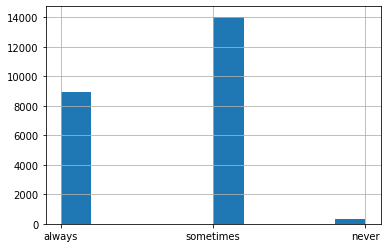

In [368]:
venn_diagram_df['classification'].hist()

In [390]:
venn_diagram_df.head()

,entity,classification,pct_right,number_usages,number_of_languages
0,Prius,always,100.0,16,16
1,Sundar Pichai,sometimes,95.0,19,19
2,People's Republic of China,always,100.0,17,17
3,Sint Maarten,sometimes,52.0,21,14
4,Haas House,sometimes,64.0,14,14


In [374]:
venn_diagram_df[venn_diagram_df['classification'] == 'sometimes']['pct_right'].describe()

count    14033.000000
mean        72.368061
std         22.783789
min          3.000000
25%         61.000000
50%         80.000000
75%         90.000000
max         99.000000
Name: pct_right, dtype: float64

### Somtimes Correct analysis

- almost perfect
- almost imperfect

What entities are mostly correct but just barely aren't 'always' right?

In [396]:
venn_diagram_df[venn_diagram_df['classification'] == 'sometimes'].sort_values(by='pct_right', ascending=False).head(5)

,entity,classification,pct_right,number_usages,number_of_languages
3834,Windows 7,sometimes,99.0,69,19
2419,Serbia,sometimes,99.0,88,20
711,Vietnam,sometimes,99.0,69,20
15,Catalonia,sometimes,99.0,83,20
636,Prague,sometimes,99.0,81,20


In [379]:
venn_diagram_df[(venn_diagram_df['classification'] == 'sometimes') & (venn_diagram_df['pct_right'] >= 95.0)].shape[0]

410

In [400]:
almost_perfect_entities = venn_diagram_df[(venn_diagram_df['classification'] == 'sometimes') & (venn_diagram_df['pct_right'] >= 95.0)]['entity']

In [451]:
almost_perfect_entities.shape[0]

410

In [454]:
almost_perfect_rows = []
for e in almost_perfect_entities:
    rows = get_rows_by_entity(e)
    almost_perfect_rows.append(rows)

almost_perfect_rows = pd.concat(almost_perfect_rows, axis=0)

english_entities = []
for d_id in list(almost_perfect_rows.dataset_id):
    english_entities.append(dataset_id_to_eng_subject[d_id])

almost_perfect_rows['english_entity'] = english_entities

In [455]:
almost_perfect_rows.shape

(476, 13)

In [460]:
almost_perfect_rows.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id,english_entity
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2,Sundar Pichai
13,rome_2650,"Донкеи Конг, производ који производи <br> Донк...",Нинтендо,Аппле,P178,Донкеи Конг,Нинтендо,False,Serbian,sr,developer,14,Donkey Kong
209,rome_19597,Офіційною мовою Каталонії є,Іспанська,англійська,P37,Каталонія,Іспанська,False,Ukrainian,uk,official language,5636,Catalonia
4228,calinet_3231,"Oficialment, l'irlandès és la llengua del <br>...",Comtat de Cork,les Tortugues,P37,Comtat de Cork,irlandès,False,Catalan,ca,official language,66389,County Cork
70,rome_14211,"Сониц Дрифт, креиран од стране <br> Сониц Дриф...",Сега,Аппле,P178,Сониц Дрифт,Сега,False,Serbian,sr,developer,71,Sonic Drift


In [468]:
# write to csv
# ../../data/error_analysis/almost_perfect_entities.csv
almost_perfect_rows.to_csv('../../data/error_analysis/almost_perfect_entities.csv', index=False)

What entities are mostly wrong but just barely aren't 'never' right

In [380]:
venn_diagram_df[(venn_diagram_df['classification'] == 'sometimes') & (venn_diagram_df['pct_right'] <= 5.0)].shape[0]

20

In [458]:
almost_imperfect_entities = venn_diagram_df[(venn_diagram_df['classification'] == 'sometimes') & (venn_diagram_df['pct_right'] <= 5.0)]['entity']

In [459]:
almost_imperfect_rows = []
for e in almost_imperfect_entities:
    rows = get_rows_by_entity(e)
    almost_imperfect_rows.append(rows)

almost_imperfect_rows = pd.concat(almost_imperfect_rows, axis=0)

english_entities = []
for d_id in list(almost_imperfect_rows.dataset_id):
    english_entities.append(dataset_id_to_eng_subject[d_id])

almost_imperfect_rows['english_entity'] = english_entities

In [463]:
almost_imperfect_rows.shape

(387, 13)

In [469]:
almost_imperfect_rows.to_csv('../../data/error_analysis/almost_imperfect_entities.csv', index=False)

### Check for Correlations

In [391]:
almost_imperfect_entities = venn_diagram_df[(venn_diagram_df['classification'] == 'sometimes') & (venn_diagram_df['pct_right'] <= 5.0)]['entity']

Is there a correlation between the number of times an entity appears and how accurate it is?

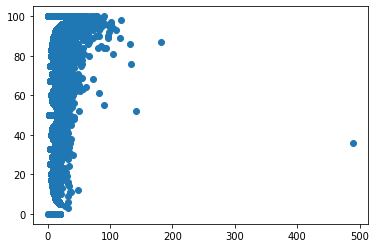

In [392]:
plt.scatter(venn_diagram_df['number_usages'], venn_diagram_df['pct_right'])
plt.show()

No

In [393]:
venn_diagram_df['number_usages'].corr(venn_diagram_df['pct_right'])

-0.012017660601239098

Is there a correlation between the number of langs an entity appears and how accurate it is?

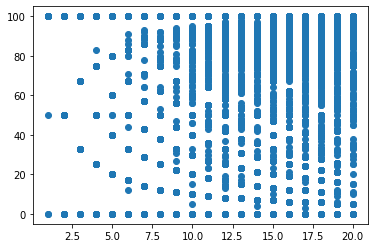

In [394]:
plt.scatter(venn_diagram_df['number_of_languages'], venn_diagram_df['pct_right'])
plt.show()

No

In [395]:
venn_diagram_df['number_of_languages'].corr(venn_diagram_df['pct_right'])

-0.055939493347825615